In [1]:
import json
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette('colorblind')

Replicating Wilcox et al's basic results before island constraints.

In [26]:
all_outputs = os.listdir("grammar_outputs/wilcox_replication")
basic_outputs = [output_file for output_file in all_outputs if "basic" in output_file]
basic_effects = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication", output_filename)))
    stim_id = 1
    # get model/construction (subj obj or pp) from filenames
    model_name = output_filename.split(".json")[0][-4:]
    construction_name = output_filename.split(".json")[0].split("_")[1]
    for stim_set in construction_data:
        basic_effects.append({
            "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "gap",
            "wh_effect": stim_set['s_ab']['critical_surprisal'] - stim_set['s_xb']['critical_surprisal']
        })
        basic_effects.append({
                        "item": stim_id,
            "model": model_name,
            "test": construction_name,
            "gap": "nogap",
            "wh_effect": stim_set['s_ax']['critical_surprisal'] - stim_set['s_xx']['critical_surprisal']
        })
        stim_id +=1


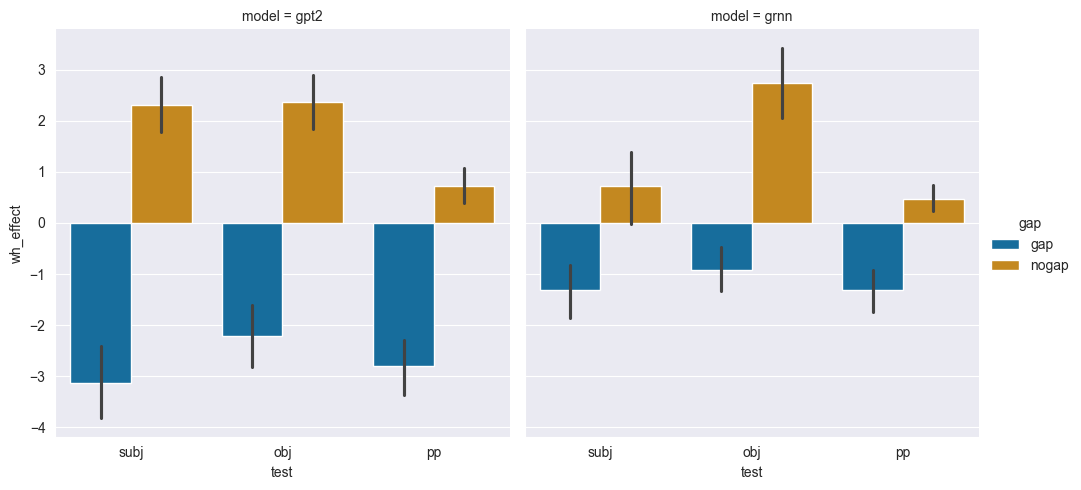

In [27]:
basic_effects = pd.DataFrame(basic_effects)
sns.catplot(x="test", y="wh_effect", hue="gap", data=basic_effects, kind="bar", col = "model",
            estimator="mean")
if "figures" not in os.listdir("."):
    os.mkdir("figures")
plt.savefig("figures/basic_fg.png")

Wilcox et al: run "Linear mixed-effects models on raw surprisal values with sum-coded conditions and by-item random slopes". We're looking for a significantly negative interaction term between the presence & absence of gaps.

In order to do this, we need to re-read the files for raw surprisal values and make features to put into our regression model (wh/that, gap/nogap)

In [28]:
def modify_base_dict(sentence_key, stim_set, base_dict):
    sent_copy = base_dict.copy()
    # replace 0 with -1 for island
    if sentence_key == "s_ab":
        sent_copy['wh'] = 1
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_xb":
        sent_copy['wh'] = 0
        sent_copy['gap'] = 1
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    elif sentence_key == "s_ax":
        sent_copy['wh'] = 1
        sent_copy['gap'] = 0
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    else: # s_xx
        sent_copy['wh'] = 0
        sent_copy['gap'] = 0
        sent_copy['surprisal'] = stim_set[sentence_key]['critical_surprisal']
    return sent_copy

In [29]:
basic_surprisals = []
for output_filename in basic_outputs:
    construction_data = json.load(open(os.path.join("grammar_outputs", "wilcox_replication",output_filename)))
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    for i in construction_data:
        model_name = output_filename.split(".json")[0][-4:]
        construction_name = output_filename.split(".json")[0].split("_")[1]
        for stim_set in construction_data:
            base_info = {
                "item": stim_id,
                "model": model_name,
                "test": construction_name
            }
            basic_surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
            basic_surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
            stim_id +=1

In [33]:
basic_surprisals = pd.DataFrame(basic_surprisals)

We now fit mixed-effects models for each model & condition

In [34]:
from pymer4.models import Lmer

In [35]:
def fit_regression_model(lm, condition, surprisal_data, formula):
    condition_data = surprisal_data[(surprisal_data['model'] == lm) & (surprisal_data['test'] == condition)]
    model = Lmer(formula, data = condition_data)
    model.fit()
    return model.summary()

In [36]:
import itertools

In [39]:
basic_surprisals

,item,model,test,wh,gap,surprisal
0,1,gpt2,subj,1,1,13.879699
1,1,gpt2,subj,0,1,19.175135
2,1,gpt2,subj,1,0,26.325025
3,1,gpt2,subj,0,0,25.138877
4,2,gpt2,subj,1,1,12.570331
...,...,...,...,...,...,...
59995,2499,grnn,pp,0,0,13.815731
59996,2500,grnn,pp,1,1,19.835956
59997,2500,grnn,pp,0,1,20.126006
59998,2500,grnn,pp,1,0,27.884651


In [42]:
conditions, models = basic_surprisals['test'].unique(), basic_surprisals['model'].unique()
interaction_results = []
basic_formula = "surprisal ~ wh * gap + (wh+gap || item)"
for condition, model in itertools.product(conditions, models):
    summary = fit_regression_model(model, condition, basic_surprisals, basic_formula)
    result = summary[['Estimate', 'P-val', 'Sig']].iloc[-1]
    result['model'] = model
    result['condition'] = condition
    interaction_results.append(result)


subj gpt2
boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -27058.762 	 AIC: 54133.524

Random effects:

                 Name     Var    Std
item      (Intercept)  18.778  4.333
item.1             wh   0.000  0.000
item.2            gap  37.460  6.120
Residual                3.001  1.732

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap+(wh+gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 10000	 Groups: {'item': 2500.0}

Log-likelihood: -27058.762 	 AIC: 54133.524

Random effects:

                 Name     Var    Std
item      (Intercept)  18.778  4.333
item.1             wh   0.000  0.000
item.2            gap  37.460  6.120
Residual                3.001  1.732

No random effect corr

We have a negative interaction term, and the result is statistically significant (really low p-values get rounded down to 0).

In [43]:
pd.DataFrame(interaction_results)

,Estimate,P-val,Sig,model,condition
wh:gap,-5.449,0.0,***,gpt2,subj
wh:gap,-2.036,0.0,***,grnn,subj
wh:gap,-4.579,0.0,***,gpt2,obj
wh:gap,-3.656,0.0,***,grnn,obj
wh:gap,-3.542,0.0,***,gpt2,pp
wh:gap,-1.790,0.0,***,grnn,pp


## Plotting the Island data

In [44]:
from generate_corpora import corpus_from_json
from analysis import island_effects_for_model
import pandas as pd
import seaborn as sns

In [45]:
grnn_control, grnn_island = corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_obj_grnn.json", is_tuples = True), corpus_from_json("grammar_outputs/wilcox_replication/island_cnp_that_grnn.json", is_tuples = True)
gptwiki_control, gptwiki_island = corpus_from_json("grammar_outputs/wilcox_replication/gptwiki/island_cnp_obj_gpt2.json", is_tuples = True), corpus_from_json("grammar_outputs/wilcox_replication/gptwiki/island_cnp_that_gpt2.json", is_tuples = True)
grnn_cnp_island_effects = island_effects_for_model("grnn", grnn_control, grnn_island, "wh_mvt")
gpt2_cnp_island_effects = island_effects_for_model("gpt2", gptwiki_control, gptwiki_island, "wh_mvt")
island_effects = pd.DataFrame(grnn_cnp_island_effects + gpt2_cnp_island_effects)

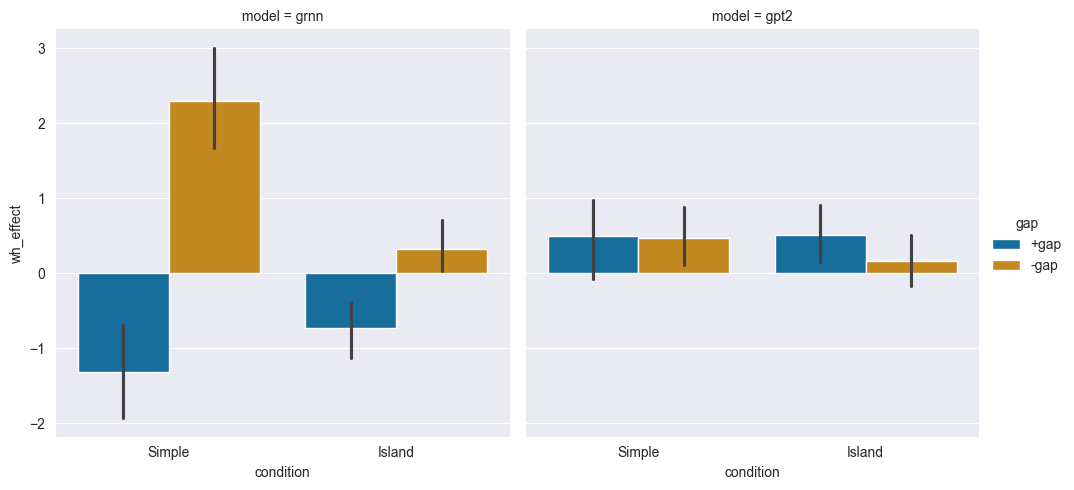

In [46]:
sns.catplot(x="condition", y="wh_effect", hue="gap", data=island_effects, kind="bar", col = "model",
            estimator="mean")
plt.savefig("figures/wilcox_cnp_island.png")

In [47]:
from analysis import * 

In [48]:
model = "gpt2"
control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)

def island_surprisals(condition_name, tuples, model_name):
    stim_id = 1
    # adding surprisals individually because that's what works with the sentence tuples
    surprisals = []
    for stim_set in tuples:
        stim_set = stim_set.to_dict()
        base_info = {
            "item": stim_id,
            "model": model_name,
            "island": 1 if condition_name == "island" else -1,
        }
        surprisals.append(modify_base_dict("s_ab", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xb", stim_set, base_info))
        surprisals.append(modify_base_dict("s_ax", stim_set, base_info))
        surprisals.append(modify_base_dict("s_xx", stim_set, base_info))
        stim_id +=1
    return surprisals

In [49]:
all_island_surprisals = []
for model_name in ["gpt2", "grnn"]:
    control_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_obj_{model_name}.json", is_tuples = True)
    island_tuples = corpus_from_json(f"grammar_outputs/wilcox_replication/island_cnp_that_{model_name}.json", is_tuples = True)
    all_island_surprisals += island_surprisals("control", control_tuples, model_name)
    all_island_surprisals += island_surprisals("island", island_tuples, model_name)

In [50]:
all_island_surprisals = pd.DataFrame(all_island_surprisals)


The three-way interaction term (filler x gap x island) is significant for both models.

In [51]:
grnn_island = all_island_surprisals[all_island_surprisals['model'] == 'grnn']
model = Lmer("surprisal~wh*gap*island+(gap||item)", data = grnn_island)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -560.925 	 AIC: 1143.850

Random effects:

                 Name     Var    Std
item      (Intercept)   9.073  3.012
item.1            gap  16.798  4.099
Residual                3.781  1.944

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -560.925 	 AIC: 1143.850

Random effects:

                 Name     Var    Std
item      (Intercept)   9.073  3.012
item.1            gap  16.798  4.099
Residual                3.781  1.944

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),18.580,17.436,19.725,0.584,27.0,31.822,0.000,***
wh,0.070,-0.185,0.325,0.130,162.0,0.539,0.591,
gap,3.077,1.537,4.616,0.785,27.0,3.917,0.001,***
island,-0.798,-1.053,-0.543,0.130,162.0,-6.143,0.000,***
wh:gap,-0.585,-0.840,-0.330,0.130,162.0,-4.503,0.000,***
wh:island,-0.174,-0.428,0.081,0.130,162.0,-1.336,0.184,
gap:island,0.877,0.622,1.132,0.130,162.0,6.750,0.000,***
wh:gap:island,0.320,0.066,0.575,0.130,162.0,2.466,0.015,*


In [52]:
gpt2_island = all_island_surprisals[all_island_surprisals['model'] == 'gpt2']
model = Lmer("surprisal~wh*gap*island+(gap||item)", data = gpt2_island)
model.fit()
model.summary()

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -545.152 	 AIC: 1112.303

Random effects:

                 Name     Var    Std
item      (Intercept)  11.885  3.447
item.1            gap   4.382  2.093
Residual                3.685  1.920

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: surprisal~wh*gap*island+(gap||item)

Family: gaussian	 Inference: parametric

Number of observations: 224	 Groups: {'item': 28.0}

Log-likelihood: -545.152 	 AIC: 1112.303

Random effects:

                 Name     Var    Std
item      (Intercept)  11.885  3.447
item.1            gap   4.382  2.093
Residual                3.685  1.920

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),15.526,14.225,16.828,0.664,27.0,23.382,0.000,***
wh,0.015,-0.236,0.266,0.128,162.0,0.117,0.907,
gap,0.980,0.165,1.795,0.416,27.0,2.357,0.026,*
island,-0.419,-0.671,-0.168,0.128,162.0,-3.269,0.001,**
wh:gap,-1.024,-1.276,-0.773,0.128,162.0,-7.986,0.000,***
wh:island,-0.081,-0.332,0.170,0.128,162.0,-0.632,0.528,
gap:island,1.416,1.165,1.668,0.128,162.0,11.044,0.000,***
wh:gap:island,0.758,0.507,1.009,0.128,162.0,5.910,0.000,***
